## Stylized Facts
Stylized facts are statistical properties that are present in many empirical asset returns (across time and markets). It is important to be aware of them because when we are building models that are supposed to represent asset price dynamics, the models should be able to capture/replicate these properties.

In this notebook, we investigate the five stylized facts using an example of daily S&P 500 returns from the years 2000 to 2020.

1. Import the required libraries:

In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

2. Download the S&P 500 and calculate the return:

In [9]:
df = yf.download("^GSPC",
                 start="2000-01-01",
                 end="2020-12-31",
                 auto_adjust=True,
                 progress=False)
df["log_rtn"] = np.log(df["Close"]/df["Close"].shift(1))
df = df[["Close", "log_rtn"]].dropna()

### Fact 1: Non-Gaussian distribution of returns
It was observed in the literature that (daily) asset returns exhibit the following:
- Negative skewness (third moment): Large negative returns occur more frequently than large positive ones
- Excess kurtosis (fourth moment): Large (and small) returns occur more often than expected under normality

We will use histogram of returns and a quantile-quantile (Q-Q) plot to investigate the existence of the first fact:

1. Calculate the Normal probability density function (PDF) using the mean and standard deviation of the observed returns:

In [13]:
r_range = np.linspace(min(df["log_rtn"]),
                      max(df["log_rtn"]),
                      num=1000)
mu = df["log_rtn"].mean()
sigma = df["log_rtn"].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

2. Plot the histogram and Q-Q:

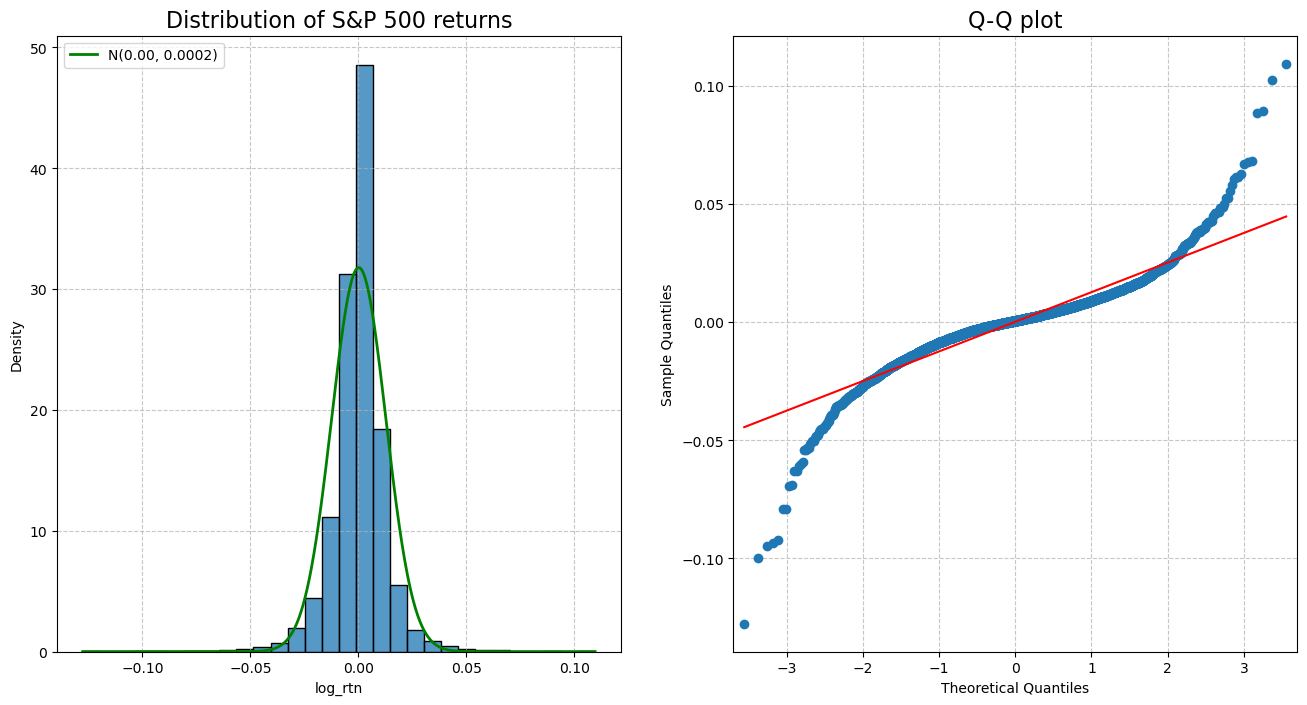

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram 
sns.histplot(df.log_rtn, bins=30, stat="density", ax=ax[0])

ax[0].set_title("Distribution of S&P 500 returns",
                fontsize=16)

# overlay normal PDF
ax[0].plot(r_range, norm_pdf, "g", lw=2,
           label=f"N({mu:.2f}, {sigma**2:.4f})")

ax[0].legend(loc="upper left")
ax[0].grid(True, linestyle="--", alpha=0.7)

# Q-Q plot
sm.qqplot(df.log_rtn.values, line="s", ax=ax[1])
ax[1].set_title("Q-Q plot", fontsize=16)
ax[1].grid(True, linestyle="--", alpha=0.7)

plt.show()

Based on the plot, more especially the Q-Q, the returns are not Normally distribiuted.

The fact that the returns do not follow the Normal distribution is crucial, given many statistical models and approaches assume that the random variable is normally distributed.

### Fact 2: Volatility clustering

Volatility clustering is the pattern in which large changes in prices tend to be followed by large changes (periods of higher volatility), while small changes in price are followed by small changes (periods of lower volatility).

To investigate the second fact we plot the log returns series:

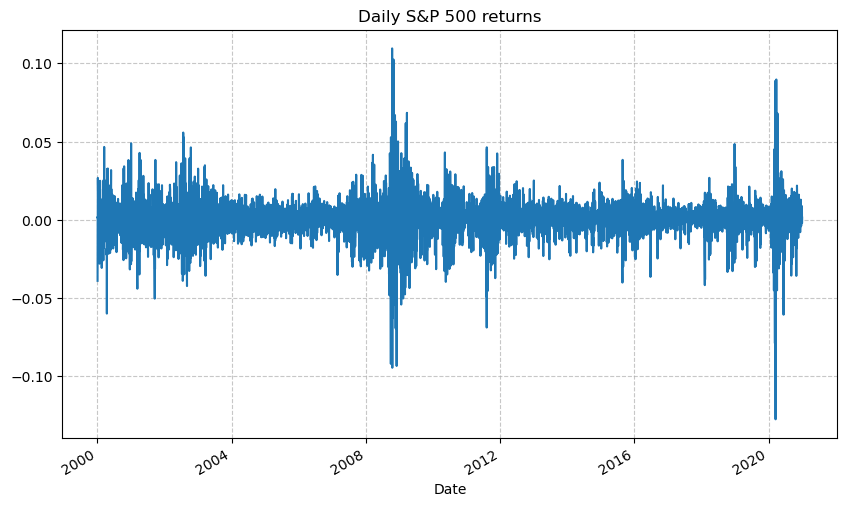

In [45]:
df["log_rtn"].plot(title="Daily S&P 500 returns", figsize=(10, 6))
plt.grid(True, linestyle="--", alpha=0.7)

We can observe clear clusters of volatility—periods of higher positive and negative returns. The fact that volatility is not constant and that there are some patterns in how it evolves is a very useful observation when we attempt to forecast volatility.

### Fact 3: Absence of autocorrelation in returns
Autocorrelation (also known as serial correlation) measures how similar a given time series is to the lagged version of itself over successive time intervals.

We investigate the third fact by stating the absence of autocorrelation in returns:

1. Define the parameters for creating the autocorrelation plots:

In [51]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

2. Run the following code to create the **autocorrelation function (ACF)** plot of log returns:

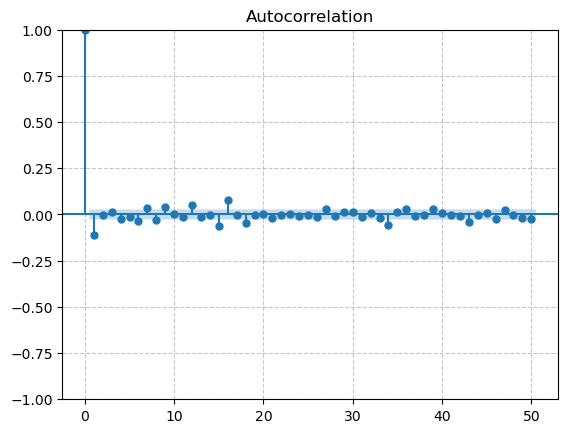

In [58]:
acf = smt.graphics.plot_acf(df["log_rtn"],
                            lags=N_LAGS,
                            alpha=SIGNIFICANCE_LEVEL)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

Only a few values lie outside of the confidence interval (we do not look at lag 0) and can be considered statistically significant. We can assume that we have verified that there is no autocorrelation in the log-returns series.

### Fact 4: Small and decreasing autocorrelation in squared/absolute returns
While we expect no autocorrelation in the return series, it was empirically proven that we can observe small and slowly decaying autocorrelation (also referred to as persistence) in simple nonlinear functions of the returns, such as absolute or squared returns. This observation is connected to the phenomenon we have already investigated, that is, volatility clustering.

The autocorrelation function of the squared returns is a common measure of volatility clustering. It is also referred to as the ARCH effect, as it is the key component of (G)ARCH models.

To investigate the fourth fact, we create the ACF plots of squared and absolute returns:

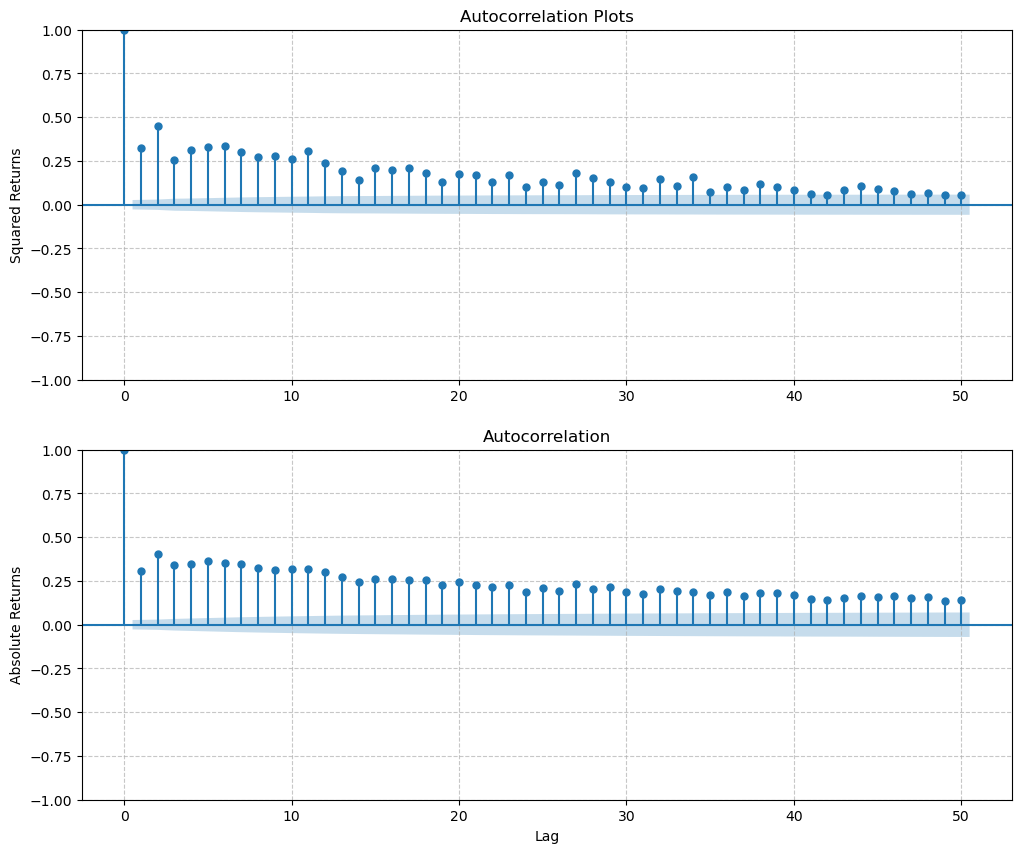

In [70]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
smt.graphics.plot_acf(df["log_rtn"]**2, lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title="Autocorrelation Plots",
          ylabel="Squared Returns")
ax[0].grid(True, linestyle="--", alpha=0.7)
smt.graphics.plot_acf(np.abs(df["log_rtn"]), lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel="Absolute Returns",
          xlabel="Lag")
ax[1].grid(True, linestyle="--", alpha=0.7)
plt.show()

We can observe the small and decreasing values of autocorrelation for the squared and absolute returns, which are in line with the fourth stylized fact.

### Fact 5: Leverage effect
The leverage effect refers to the fact that most measures of an asset’s volatility are negatively correlated with its returns.

To investigate the existence of the leverage effect in the S&P 500’s return series:

1. Calculate the volatility measures as the moving standard deviations:

In [76]:
df["moving_std_252"] = df[["log_rtn"]].rolling(window=252).std()
df["moving_std_21"] = df[["log_rtn"]].rolling(window=21).std()

2. Plot all the series:

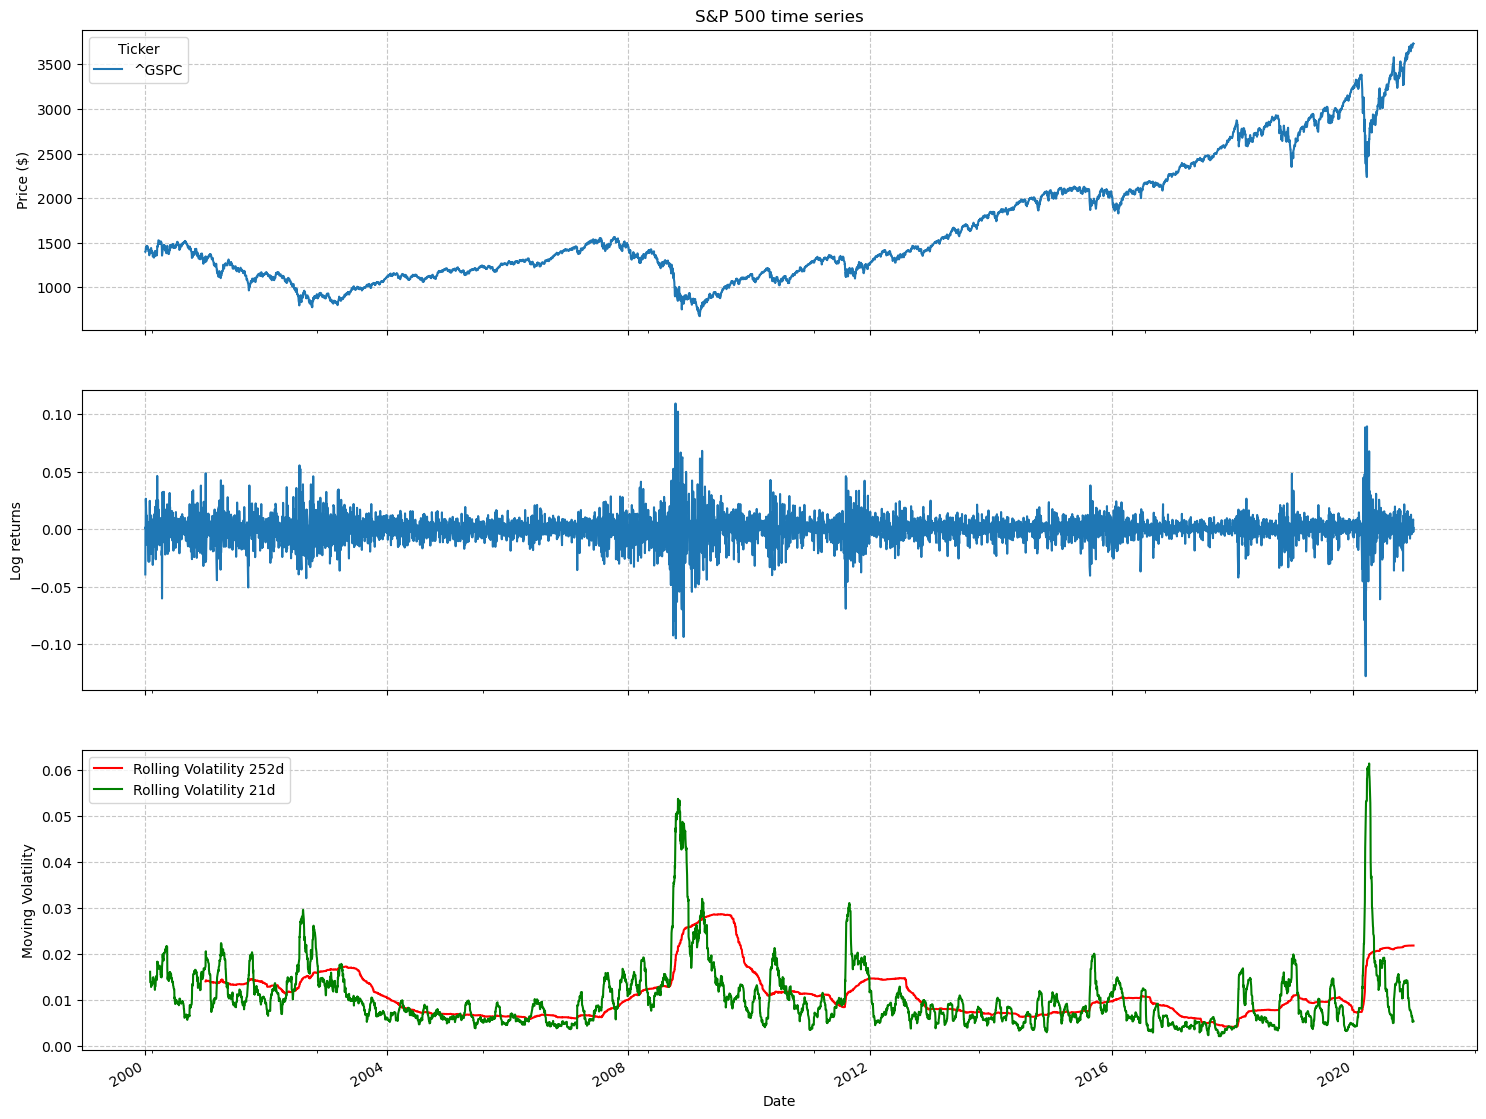

In [83]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15),
                       sharex=True)
df["Close"].plot(ax=ax[0])
ax[0].set(title="S&P 500 time series",
          ylabel="Price ($)")
df["log_rtn"].plot(ax=ax[1])
ax[1].set(ylabel="Log returns")
df["moving_std_252"].plot(ax=ax[2], color="r",
                           label="Rolling Volatility 252d")
df["moving_std_21"].plot(ax=ax[2], color="g",
                           label="Rolling Volatility 21d")
ax[2].set(ylabel="Moving Volatility",
          xlabel="Date")
ax[2].legend()
for axis in ax:
    axis.grid(True, linestyle="--", alpha=0.7)
plt.show()

we can observe a pattern of increased volatility when the prices go down and decreased volatility when they are rising. This observation is in line with the fact’s definition.